In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pyproj import CRS, Transformer
import re
import xarray as xr

import matplotlib.patheffects as pe
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Seaborn aesthetics
sns.set_context("notebook")
sns.set_theme(style="whitegrid", font_scale=1.4,
              rc={'grid.color': '#ededed'})

In [2]:
# Read the curated tree data
neon_vst = pd.read_csv("../../data/output/NEON_VST_TREES.csv")


In [3]:
## Clean data
# Use only live trees
neon_vst_filt = neon_vst[neon_vst['plantStatus'].str.contains("Live", na=False)].reset_index(drop=True)
neon_vst_filt = neon_vst_filt[~neon_vst_filt['plantStatus'].str.contains("damage|broken", na=False)].reset_index(drop=True)
# Get average crown diameter
neon_vst_filt["avgCrownDiameter"] = (neon_vst_filt["maxCrownDiameter"] + neon_vst_filt["ninetyCrownDiameter"])/2
neon_vst_filt['crownRadius'] = neon_vst_filt['avgCrownDiameter']/2
# Get vertical crown diameter
neon_vst_filt["verticalDiameter"] = neon_vst_filt["height"] - neon_vst_filt["baseCrownHeight"]
neon_vst_filt['verticalCrownRadius'] = neon_vst_filt['verticalDiameter']/2
# calculate crown volume 
hrad = neon_vst_filt["avgCrownDiameter"]/2
vrad = neon_vst_filt["verticalDiameter"]/2
# appidv_all['crown_vol'] =(4/3) * np.pi * (hrad**2) * (vrad)
neon_vst_filt['crown_vol'] =(4/3) * np.pi * (hrad**2) * ((1/4)*neon_vst_filt["height"])

# Remove data with errors (large DBH, height, etc.)
outlier_trees = ['NEON.PLA.D17.SOAP.05687']
neon_vst_filt = neon_vst_filt[~neon_vst_filt['individualID'].isin(outlier_trees)].copy().reset_index(drop=True)



In [4]:
## Lets get lat lon for each tree

# read in metadata for utm zone
neon_meta = pd.read_csv("/data/shared/src/arojas/NEON/data/NEON_Field_Site_Metadata_20230309.csv")
# get utm zone (option 1 - faster way)
# utm_num = re.findall('\d+', "UTM18N")[0]
neon_meta['utm_num'] =  [re.findall('\d+', str(x))[0] for x in neon_meta['field_utm_zone']]

# Loop through each site, reproject from utmzone to latlon
df_list = []
for name,group in neon_vst_filt.groupby("siteID"):
    
    # Get EPSG code for UTM zone
    utm_num = neon_meta.loc[neon_meta["field_domain_id"]==group['domainID'].values[0]]["utm_num"].values[0]
    crs = CRS.from_string(f"+proj=utm +zone={utm_num} +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    
    # Get easting and northing
    x = group['easting'].values
    y = group['northing'].values
    
    from_crs = CRS.from_proj4(f"+proj=utm +zone={utm_num} +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    to_crs = CRS.from_epsg(4326)

    proj = Transformer.from_crs(from_crs, to_crs, always_xy=True)
    coordinates = proj.transform(x, y)
    group["lon"] = coordinates[0]
    group["lat"] = coordinates[1]
    df_list.append(group)

# Combine and replace inf with nan
neon_vst_filt_latlon = pd.concat(df_list)
neon_vst_filt_latlon.loc[~np.isfinite(neon_vst_filt_latlon["lon"].values), "lon"]=np.nan
neon_vst_filt_latlon.loc[~np.isfinite(neon_vst_filt_latlon["lat"].values), "lat"]=np.nan

In [5]:
neon_vst_filt_latlon.columns

Index(['uid', 'namedLocation', 'date', 'eventID', 'domainID', 'siteID',
       'plotID', 'individualID', 'tempStemID', 'tagStatus', 'growthForm',
       'plantStatus', 'stemDiameter', 'measurementHeight',
       'changedMeasurementLocation', 'height', 'baseCrownHeight',
       'breakHeight', 'breakDiameter', 'maxCrownDiameter',
       'ninetyCrownDiameter', 'canopyPosition', 'shape', 'basalStemDiameter',
       'basalStemDiameterMsrmntHeight', 'maxBaseCrownDiameter',
       'ninetyBaseCrownDiameter', 'dendrometerInstallationDate',
       'initialGapMeasurementDate', 'initialBandStemDiameter',
       'initialDendrometerGap', 'dendrometerHeight', 'dendrometerGap',
       'dendrometerCondition', 'bandStemDiameter', 'remarks', 'recordedBy',
       'measuredBy', 'dataEntryRecordID', 'dataQF', 'subplotID', 'taxonID',
       'scientificName', 'easting', 'northing', 'avgCrownDiameter',
       'crownRadius', 'verticalDiameter', 'verticalCrownRadius', 'crown_vol',
       'lon', 'lat'],
      dty

In [6]:
print(neon_vst_filt.shape)
print(neon_vst_filt_latlon.shape)

(121823, 50)
(121823, 52)


In [7]:
# Lets run the point extrction


In [8]:
import rioxarray as rioxr

In [9]:
fp = "../../data/raw/raster/AI_NA_clipped.tif"
rarr = rioxr.open_rasterio(fp,mask_and_scale=True)


In [10]:
import xarray as xr
# Sample the rasters at the point locations
x_indexer = xr.DataArray(neon_vst_filt_latlon["lon"].values, dims=["point"])
y_indexer = xr.DataArray(neon_vst_filt_latlon["lat"].values, dims=["point"])

In [11]:
# rarr.x

In [12]:
# Sample Aridity raster, then check if shapes match
sampled_raster_vals = rarr.sel(x=x_indexer, y=y_indexer, method="nearest")

In [13]:
print(sampled_raster_vals.values[0].shape)
print(x_indexer.shape)

(121823,)
(121823,)


In [14]:
# add sampled values to the dataframe
neon_vst_filt_latlon['AI'] = sampled_raster_vals.values[0]/10000

In [15]:
# Colro dict!
color_dict = {"D01":'#1f77b4',
              "D02": '#aec7e8',
              "D03":'#ff7f0e',
              "D04": '#ffbb78',
              "D05":'#2ca02c',
              "D06": '#98df8a',
              "D07":'#d62728',
              "D08": '#ff9896',
              "D09":'#9467bd',
              "D10": '#c5b0d5',
              "D11":'#8c564b',
              "D12": '#c49c94',
              "D13":'#e377c2',
              "D14": '#f7b6d2',
              "D15":'#7f7f7f',
              "D16": '#c7c7c7',
              "D17":'#bcbd22',
              "D18": '#dbdb8d',
              "D19": '#17becf',
              "D20": '#9edae5'
             }


In [18]:
# get colors for plotting
# from matplotlib.cm import get_cmap
# from matplotlib.colors import Normalize, rgb2hex

# cmap = get_cmap('tab20', 20)
# cmap_list = []
# for i in range(cmap.N):
#     rgba=cmap(i)
#     cmap_list.append(rgb2hex(rgba))

# print(cmap_list)

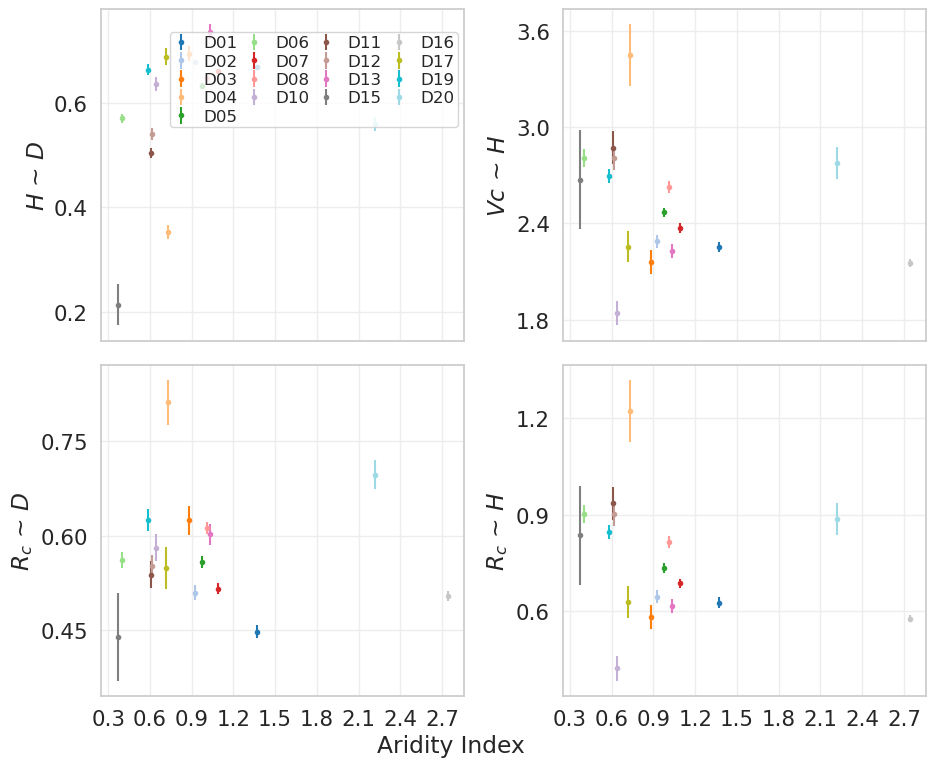

In [16]:
# Lets rerun some analysis using (copy figure 2 from Tallo paper)
# Get HSE for:
# H ~ D
# CR ~ D
# CR ~ H
# VC ~ H
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import MaxNLocator
# Init plot
fig,axs = plt.subplots(2,2,figsize=(10,8),sharex=True)
ax = axs.flatten()
color_idx = 0

outdir="allyears"

# for each domain, get regression then plot
for domain, dgroup in neon_vst_filt_latlon.groupby("domainID"):
    if np.isin(domain, ["D09", "D14"]):
        continue
    
    # Get average AI
    ai_avg = dgroup['AI'].mean()
    
    ## H ~ D
    # Get x,y, then perform regression
    x = np.log(dgroup['stemDiameter'].values)
    y = np.log(dgroup['height'].values)
    filt_bool = (np.isfinite(x) & np.isfinite(y))
    x = x[filt_bool]
    y = y[filt_bool]
    
    # Run simple OLS regression and get confidence intervals
    alpha = 0.05 # 95% confidence interval
    lr = sm.OLS(y, sm.add_constant(x,prepend=False)).fit()
    conf_interval = lr.conf_int(alpha)
    
    # Plot
    ax[0].errorbar(ai_avg, lr.params[0], yerr=conf_interval[0][1]-lr.params[0],fmt=".",
                   label=domain,color=color_dict[domain])
#     ax[0].scatter(ai_avg, lr.params[0], cmap="tab20")
    ax[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
    ax[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
    
       
    ## Vc ~ H
    # Get x,y, then perform regression
    x = np.log(dgroup['height'].values)
    y = np.log(dgroup['crown_vol'].values)
    filt_bool = (np.isfinite(x) & np.isfinite(y))
    x = x[filt_bool]
    y = y[filt_bool]
    
    try:
        # Run simple OLS regression and get confidence intervals
        alpha = 0.05 # 95% confidence interval
        lr = sm.OLS(y, sm.add_constant(x,prepend=False)).fit()
        conf_interval = lr.conf_int(alpha)

        # Plot
        ax[1].errorbar(ai_avg, lr.params[0], yerr=conf_interval[0][1]-lr.params[0],fmt=".",
                       label=domain,color=color_dict[domain])
        ax[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        
    except:
        print(f"Not enough crown_vol data for regression at domain: {domain}")
    
    
    ## CR ~ D
    # Get x,y, then perform regression
    x = np.log(dgroup['stemDiameter'].values)
    y = np.log(dgroup['crownRadius'].values)
    filt_bool = (np.isfinite(x) & np.isfinite(y))
    x = x[filt_bool]
    y = y[filt_bool]
    
    try:
        # Run simple OLS regression and get confidence intervals
        alpha = 0.05 # 95% confidence interval
        lr = sm.OLS(y, sm.add_constant(x,prepend=False)).fit()
        conf_interval = lr.conf_int(alpha)
        # Plot
        ax[2].errorbar(ai_avg, lr.params[0], yerr=conf_interval[0][1]-lr.params[0],fmt=".",
                       label=domain,color=color_dict[domain])
        ax[2].yaxis.set_major_locator(MaxNLocator(nbins=4))
        
    except:
        print(f"Not enough crown radius data for regression at domain: {domain}")
    
    
    ## CR ~ H
    # Get x,y, then perform regression
    x = np.log(dgroup['height'].values)
    y = np.log(dgroup['crownRadius'].values)
    filt_bool = (np.isfinite(x) & np.isfinite(y))
    x = x[filt_bool]
    y = y[filt_bool]
    
    try:
        # Run simple OLS regression and get confidence intervals
        alpha = 0.05 # 95% confidence interval
        lr = sm.OLS(y, sm.add_constant(x,prepend=False)).fit()
        conf_interval = lr.conf_int(alpha)

        # Plot
        ax[3].errorbar(ai_avg, lr.params[0], yerr=conf_interval[0][1]-lr.params[0],fmt=".",
                       label=domain,color=color_dict[domain])
        ax[3].yaxis.set_major_locator(MaxNLocator(nbins=4))
        
    except:
        print(f"Not enough crownRadius data for regression at domain: {domain}")
 
    
    color_idx+=1
##################
    
## Subplot aesthetics
ax[0].set_ylabel("$H$ ~ $D$")
ax[1].set_ylabel("$Vc$ ~ $H$")
ax[2].set_ylabel("$R_{c}$ ~ $D$")
ax[3].set_ylabel("$R_{c}$ ~ $H$")
# ax[3].set_xlabel("Aridity Index")
fig.text(0.5, 0.04, 'Aridity Index', ha='center')

h,l = ax[0].get_legend_handles_labels()
# ax[0].set_ylim(0,50)
fig.tight_layout()
fig.legend(h,l, loc="upper left", ncols=4,fontsize=12,
           bbox_to_anchor=(0.21,0.95),
           borderpad=0.2,labelspacing=0.2,handlelength=1,columnspacing=0.5)
fig.subplots_adjust(bottom=0.11,left=0.15)
fig.savefig(f"../../figs/veg-struct/allom/{outdir}/DOMAINS-ALLOMS-AI.png", dpi=300)
plt.show()



1.7394232835075627
1.6604901885155643
1.7197334933461472
3.217625716836586
1.6902396619639832
1.698675359837825
1.653193172981113
1.456547004582995
27.28758891508408
2.2984608738306793
2.099473194263141
1.8945593887287737
1.4859106236648314
7.186617260916982
7.712402198764893
1.5999780987110395
1.6494930277084485
1.320146623898093
1.802898081875814


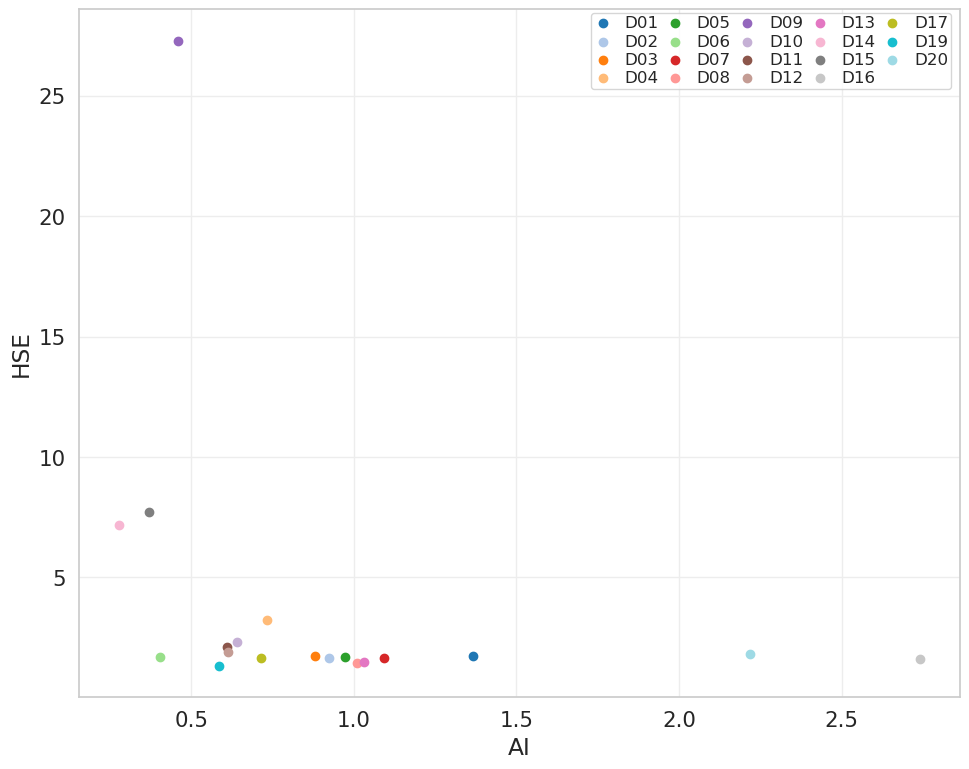

In [18]:
# Lets rerun some analysis using (copy figure 2 from Tallo paper)
# Get HSE for:
# H ~ D
# CR ~ D
# CR ~ H
# VC ~ H
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import MaxNLocator
# Init plot
fig,ax = plt.subplots(1,figsize=(10,8),sharex=True)
color_idx = 0
outdir="allyears"

# for each domain, get regression then plot
for domain, dgroup in neon_vst_filt_latlon.groupby("domainID"):
    
    # Get average AI
    ai_avg = dgroup['AI'].mean()
    
    ## H ~ D
    # Get x,y, then perform regression
    x = np.log(dgroup['stemDiameter'].values)
    y = np.log(dgroup['height'].values)
    filt_bool = (np.isfinite(x) & np.isfinite(y))
    x = x[filt_bool]
    y = y[filt_bool]
    
    # Run simple OLS regression
    lr = sm.OLS(y, sm.add_constant(x,prepend=False)).fit()
    beta = lr.params[0]
    # 95% confidence interval
    conf_interval_beta = lr.conf_int(0.05)
    
    
    ## Vc ~ H
    # Get x,y, then perform regression
    x = np.log(dgroup['height'].values)
    y = np.log(dgroup['crown_vol'].values)
    filt_bool = (np.isfinite(x) & np.isfinite(y))
    x = x[filt_bool]
    y = y[filt_bool]
    
    try:
        # Run simple OLS regression and get confidence intervals
        lr = sm.OLS(y, sm.add_constant(x,prepend=False)).fit()
        alpha = lr.params[0] # 95% confidence interval
        conf_interval_alpha = lr.conf_int(0.05)
        
    except:
        print(f"Not enough crown_vol data for regression at domain: {domain}")
        continue
        
    # Get HSE and plot!
    HSE = (1+2/beta)-alpha
    print(HSE)
    # Plot
    ax.scatter(ai_avg, HSE,label=domain,color=color_dict[domain])
    
    color_idx+=1
##################
    
## Subplot aesthetics
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))

# ax.set_ylim(0, 12)

ax.set_xlabel("AI")
ax.set_ylabel("HSE")
h,l = ax.get_legend_handles_labels()
# ax[0].set_ylim(0,50)
fig.tight_layout()
fig.legend(h,l, loc="upper right", ncols=5,fontsize=12,bbox_to_anchor=(0.975,0.975),
           borderpad=0.2,labelspacing=0.2,handlelength=1,columnspacing=0.5)
fig.savefig(f"../../figs/veg-struct/allom/{outdir}/DOMAINS-HSE-AI.png", dpi=300)
plt.show()

